# Notebook 2 - Building Models to Predict NASDAQ-100 Returns

In this notebook, I basically trained different machine learning models to answer the 3 sub-research questions I came up with for my project:

### **RQ1:** Can simple classical models (Linear Regression and Random Forest) predict next-day returns?  
### **RQ2:** Does a deep learning model such as LSTM perform better than classical models?
### **RQ3:** Are next-day returns easier to predict than next-week returns?

I kept the modeling process simple and focused on understanding rather than complexity. My goal here is not to beat Wall Street, but to learn how different models behave on financial time-series data.

To give a breakdown of what I do in this notebook, I will:
1. Load the processed dataset from Notebook 1  
2. Prepare training and test splits using time-based separation  
3. Train Linear Regression  
4. Train Random Forest  
5. Train a simple LSTM model using PyTorch
6. Improvise the LSTM model to build a Deep LSTM version
7. Plot predictions vs. actual values  
8. Write short analyses after each experiment to give my view on the outputs.

Being consistent with the formatting of my project, I will give a detailed step-by-step approach of how I tackle the questions using the models I develop.

## Step 1 - Load the Preprocessed Dataset

Here I load the cleaned dataset that I saved in Notebook 1. This dataset already contains
- log returns  
- moving averages  
- volatility  
- RSI  
- next-day and next-week target returns  

The goal of this notebook is to use these features to train prediction models.

In [2]:
#importing some of the important modules that I need for my project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

#loading the dataset into a simple variable called data
data = pd.read_csv("nasdaq_processed.csv")
data.head()

,index,date,close,high,low,open,volume,log_return,ma5,ma20,volatility,rsi,target_next_day_return,target_next_week_return,target_direction
0,20,2000-02-01,3701.780029,3703.590088,3544.929932,3580.290039,1398240000,0.036234,3586.463965,3628.669995,0.037532,56.083963,0.006108,0.093051,1
1,21,2000-02-02,3724.459961,3785.360107,3693.949951,3700.199951,1527880000,0.006108,3607.113965,3637.582996,0.034236,59.850592,0.033453,0.063456,1
2,22,2000-02-03,3851.159912,3857.340088,3704.229980,3726.129883,1722330000,0.033453,3658.715967,3654.775488,0.034755,59.616737,0.006009,0.060171,1
3,23,2000-02-04,3874.370117,3929.810059,3856.830078,3858.600098,1751450000,0.006009,3744.364014,3681.453491,0.032412,57.226972,0.015106,0.024103,1
4,24,2000-02-07,3933.340088,3933.750000,3858.889893,3873.429932,1625540000,0.015106,3817.022021,3701.640491,0.030503,57.442010,0.032376,0.013332,1


## Step 2 - Select Input Features and Prediction Targets

For my models, I used a small but meaningful set of features:

- log return  
- MA5  
- MA20  
- volatility  
- RSI  

These features capture short-term trends, medium trends, and price momentum.  
To keep the project simple, I did not add too many indicators.

My prediction target for Notebook 2 is:

### **next-day return**  
because RQ1 and RQ2 focus on predicting **tomorrow**, not next week.

In [3]:
feature_cols = ["log_return", "ma5", "ma20", "volatility", "rsi"]
target_col = "target_next_day_return"

X = data[feature_cols]
y = data[target_col]

## Step 3 - Time-Based Train/Test Split

Since this is time-series data, I cannot randomly shuffle it.

So I used an 80/20 split **based on time**:
- the first 80% of data is **training** 
- the last 20% is **testing**  

This makes the evaluation more realistic, because the model predicts the future based on the past, just like real markets work.

In [4]:
split_idx = int(len(X) * 0.8) #calculating the index that basically represents 80% of the data
# the above line is important, because I use this to split the dataset into training and testing sets

X_train = X.iloc[:split_idx] #everything before the split index becomes my training features
y_train = y.iloc[:split_idx] #similar split but its for the training target values

X_test = X.iloc[split_idx:] #everything post the split index basically becomes my testing features
#thus the above line means that it consists of the most recent data the model has not seen or come across
y_test = y.iloc[split_idx:] #this is the test set for the target values

## Step 4 - Standardize the Input Features

I standardized the features so that all of them have similar scales.  
This helps linear models and neural networks train more effectively.

Another imporrtant thing to note is: 

**I fit the scaler only on the training data to avoid data leakage.**

In [15]:
from sklearn.preprocessing import StandardScaler # I use StandardScaler to put
#all my features on a similar scale because this helps the model learn better as
#some columns such as price are much larger than columns like returns

scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train) # I fit the scaler on the training data and scale it
X_test_scaled = scaler.transform(X_test) #for test data I apply the same scaling.

Resonating upon why I used StandardScaler. I basically scaled all my input features so they are on the same scale. The reason I decided to do this is because often some models tend to have inefficient outcomes and behave poorly when one feature has huge values (example price) and another feature is smaller in values (example returns). So basically StandardScaler solves this by turning every feature into a set of mean=0 and std=1. Talking about why I fit scaler only on training data is mainly to avoid data leakage.

# Research Question 1  
## Can classical models predict next-day returns?

### Model 1: Linear Regression

I started with Linear Regression because it is one of the simplest models in machine learning. I got an introduction to this model in the CS 171 class itself which is also why I wanted to implement it for my own project. Linear regression helps me understand whether there is a simple linear relationship between the indicators I created and the next-day return.

I don’t expect perfect accuracy because financial markets are extremely noisy, but this gives me a good baseline.

To explain what exactly I am doing below. I am using Linear Regression as a baseline for RQ1. Initially I train the model on scaled training data and then I used the model to predict the returns in the test set. Also in order to measure how well it performed, I ensured to calculated the Mean Squared Error (MSE).

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

lr_predictions = lin_reg.predict(X_test_scaled)

lr_mse = mean_squared_error(y_test, lr_predictions)
lr_mse

0.0002733094990144006

The Mean Squared Error (MSE) for my Linear Regression model is: 0.0002733 which is an extremely small value but again thats because **returns** are themselves small numbers. As I proceed further into the project I will compare the MSE of this model to other models to see which model does a better job at predicting the next-day returns.

### Plot - Linear Regression Predictions vs Actual

Here I plotted the predicted returns against the actual returns.  
This helps me visually check whether the model is capturing basic patterns in the market.

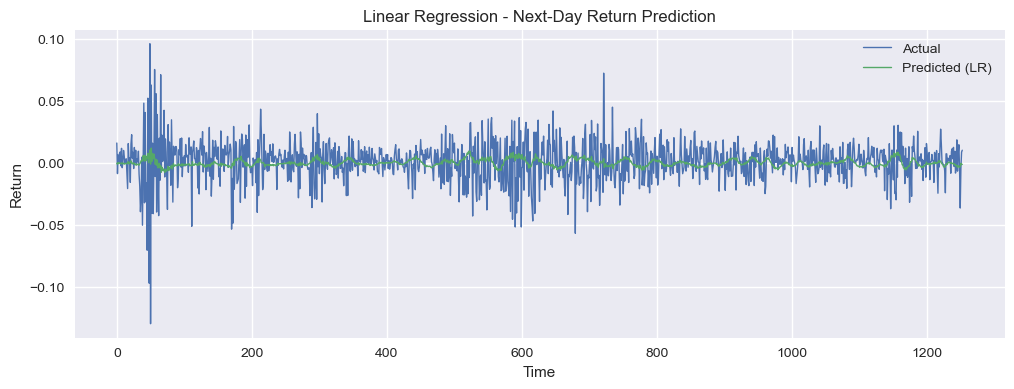

In [17]:
plt.figure(figsize=(12,4))
plt.plot(y_test.values, label="Actual", linewidth=1)
plt.plot(lr_predictions, label="Predicted (LR)", linewidth=1)
plt.title("Linear Regression - Next-Day Return Prediction")
plt.xlabel("Time")
plt.ylabel("Return")
plt.legend()
plt.show()

To give a breakdown of the plot:
- the blue line represents **actual returns**
- the green line represents **predicted returns**
  
Tabulating the above plot it is evident that the actual returns is extremely noisy which is something that I expected considering the fact that daily stock returns are noisy. The green line which is the predicted returns is smoother and stays close to zero which is again an expected behavior of Linear Regression on noisy financial time-series.

### RQ1 - Linear Regression Analysis

Now, Linar Regression can only learn linear relationships and financial returns within NASDAQ-100 and S&P500 are extremely noisy and non-linear. 

Hence from the plot, I noticed that Linear Regression follows the general shape of the returns,
but it struggles with sudden spikes and drops. This makes sense because again the market is very noisy
and the linear model can only capture simple straight-line relationships.

Some more important things to note is that:
- since the relationships between technical indicators and returns is non-linear thus the plot was flat
- returns are truly noisy
- linear models are unable to capture complex and abrupt movements.

Overall linear regression still gives me a good baseline for comparison.

## Model 2: Random Forest

Next, I used a Random Forest Regressor.  
This model can capture more complex patterns because it combines many decision trees.

I learned about Random Forest through many platforms such as Geek for Geeks, Scikit-learn, IBM, Youtube. The references for these resources are:
- https://www.geeksforgeeks.org/machine-learning/random-forest-regression-in-python/
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
- https://www.ibm.com/think/topics/random-forest

I also additionally watched a video on Random Forest Regressor related to Stock Price by this channel:
https://www.youtube.com/watch?v=0WMYoBItMxE

Thus based on all this I chose Random Forest because:
- it is easy to interpret  
- it handles non-linear patterns  
- it often performs better than simple linear models on noisy data

In [18]:
from sklearn.ensemble import RandomForestRegressor #imports random forest regressor from scikit-learn

rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    max_depth=8
) #this basically creates a random forest model, builds 200 decision trees

rf_model.fit(X_train_scaled, y_train) #this line is responsible for training the model using the scaled training feautres and training labels (next-day return)
rf_predictions = rf_model.predict(X_test_scaled) #uses the trained model to predict returns on the test set. 

rf_mse = mean_squared_error(y_test, rf_predictions) #this line is responsible for calculating MSE
rf_mse

0.00026314561242952284

Talking more about the Random Forest Regressor Model that I used for my project. What the code above does is it basically articulates a Random Forest Model with the features:
- **n_estimators = 200** means that the model builds 200 decision trees
- **max_depth = 8** limits how deep each of the trees can grow (this is responsible for preventing overfitting)
- **random_state = 42** basically makes the results reproducible when someone else is going to run the program and code

Moreover, the Random Forest Model produces a MSE of 0.00026 which is slightly lower than the **Linear Regression** MSE (0.00027). A very interesting fact is that since my projects objecive is to predict very small log-return values thus even smallest of decrement in MSE means the model is learning a bit more structure in the data.

### Plot - Random Forest Predictions vs Actual

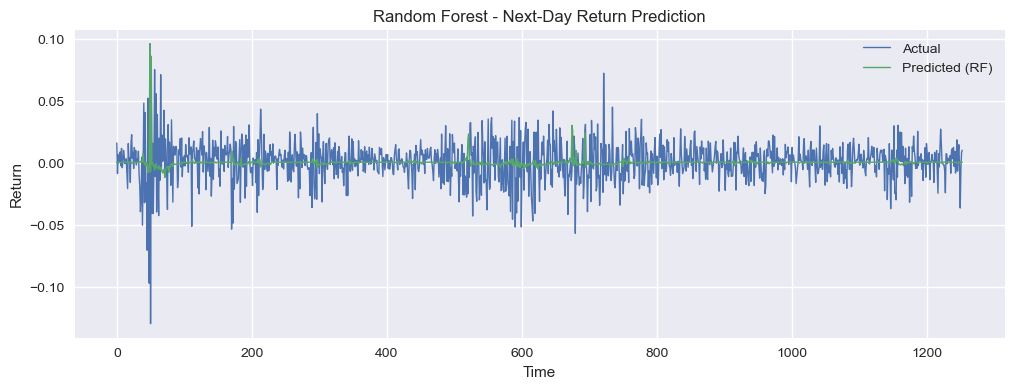

In [19]:
plt.figure(figsize=(12,4))
plt.plot(y_test.values, label="Actual", linewidth=1)
plt.plot(rf_predictions, label="Predicted (RF)", linewidth=1)
plt.title("Random Forest - Next-Day Return Prediction")
plt.xlabel("Time")
plt.ylabel("Return")
plt.legend()
plt.show()

### RQ1 - Random Forest Analysis

My analysis of the plot revealed that the actual returns (blue line) have significant fluctuations and spikes up and down with high noise, while the predicted returns (green line) are once again very close to zero. Once more, this is exactly what I anticipated when forecasting financial returns for the following day.

Thus based on the plot I would say:
- Random Forest model that I developed does better than Linear Regression as it picks up some of the spikes and small, local patterns in the data.
- Since the MSE difference is extremely small, the improvement in the model is very small. A reason for this is also because next-day returns behave almost like random noise.
- Based on the lack of spikes and matching pattern of predicted returns and actual returns it is clearly evident that the random forest model cannot learn the unpredicatable shocks in the market.

So the conclusion would be that Random Forest performs slightly better than Linear Regression but again it too struggles to capture the pattern primarily due to the extreme noise and unpredictability in the markets which make next-day returns prediction truly difficult.

## RQ1 Summary - Linear Regression & Random Forest (Classical Models)

Based on the MSE values and the plots:

- Linear Regression captured some general structure but missed sharp movements.
- Random Forest performed slightly better and followed the patterns bit more closely.

This tells me that simple non-linear models can understand financial data better than pure linear models. 

The outputs of the two classical models certainly support the financial theory that the short-term returns of stock market have **extremely weak predictability** despite implementing advanced models. 

Next, I will move to RQ2 and test whether an LSTM (a sequence model) performs even better.

# Research Question 2  
## Does an LSTM perform better than classical models?

From my research and experience in CS 171 I have learned that LSTMs are designed for sequence data, so they should theoretically understand time dependencies better than Random Forest or Linear Regression.

I learned about LSTM from a vast variety of sites such as:
- https://www.geeksforgeeks.org/deep-learning/deep-learning-introduction-to-long-short-term-memory/
- https://www.youtube.com/watch?v=b61DPVFX03I

I learned about specific implementation of LSTM to NASDAQ-100 via:
- https://dl.acm.org/doi/10.1145/3677779.3677837
- https://www.sciencedirect.com/science/article/pii/S2666827024000938
- https://www.youtube.com/watch?v=Vbj2Zzwg8jc

Now, to keep things simple I built a small LSTM:
- 1 LSTM layer  
- 1 fully connected layer  
- Trained for a small number of epochs  

My goal for this model is educational and not to overengineer the best financial model.

In [21]:
#importing pytorch and the neural network module
import torch
import torch.nn as nn

# converting to tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32)

X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32)

# reshaping for LSTM
X_train_t = X_train_t.unsqueeze(1)
X_test_t = X_test_t.unsqueeze(1)

Giving a better understanding of the code above. Since PyTorch models mainly work with tensors and not with pandas arrays thus as the first steps I basically converted all my scaled training and test data into tensors which I highlighted in the code above. Next up to ensure LSTM can learn from the features and target values, I converted the target values **y_train** and **y_test** to float tensors. 

Now the LSTM's basically expect the input to have 3 dimensions which include:
- **batch_size**, **sequence_length** and the **number_of_features**

Since the aim of my project is to predict returns one day at a time thus my data only has a single time step and thus there is no real **sequence** in the data. However, because I have learned that LSTM's need the input to have a sequence dimension thus as a result to resolve the issue I used .unsqueeze(1) to add a sequence length of 1. This particular line of code does not change any of my data it just simply reshapes it into the format which is accepted by LSTM.

### LSTM Architecture Description

I used a very small architecture and built a relatively small LSTM model because the main objective of my project is to understand how LSTM behaves on financial data without an overly-complicated architecture.

Thus the architecture is:
- 1 LSTM layer  
- Hidden size: 16  
- 1 linear layer that turns the output from the LSTM model into a single predicted return.
- Mean Squared Error (MSE) Loss Function and use of Adam Optimizer

Even though the model I developed is small, it still has the ability to capture short-range temporal patterns in the NASDAQ-100 data. A benefit of a concise architecture for LSTM is faster training, easier to explain, lower chance of overfitting.

In [237]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=16):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True) #lstm layer that reads the input features
        self.fc = nn.Linear(hidden_dim, 1) #this is the final layer that basically produces a single predicted return
        
    def forward(self, x):
        out, _ = self.lstm(x) #run the input through lstm
        out = out[:, -1, :] #retrieve output from last time step
        return self.fc(out) #pass the output through the linear layer to get the final prediction

#building the model
model = SimpleLSTM(input_dim=X_train_t.shape[2])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #adam optimizer

### Training the LSTM

I trained the model for 50 epochs.  
Since this is financial data (very noisy), I don't expect perfect accuracy, but I want to see whether it performs better than the classical models.

In [238]:
losses = []

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_t).squeeze()
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

### Training Loss Plot

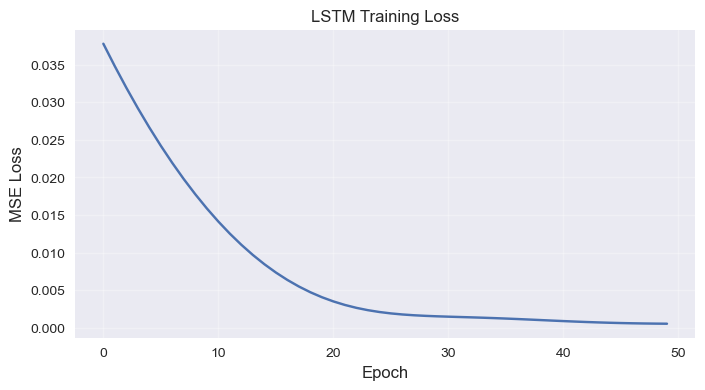

In [239]:
plt.figure(figsize=(8,4))
plt.plot(losses)
plt.title("LSTM Training Loss")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("MSE Loss", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

**Analysis of the plot:**
The plot that I have created above certainly looks normal and shows a healthy training curve. As it can be seen the LSTM loss decreases rapidly in the beginning of the first few range of epoch values and then the curve flattens out which means that the model has learned whatever small patterns exist in the training data. After roughly 20-30 epoochs the improvement is much smaller which is again expected because of how noisy financial data is.

### LSTM Predictions vs Actual (Test Set)

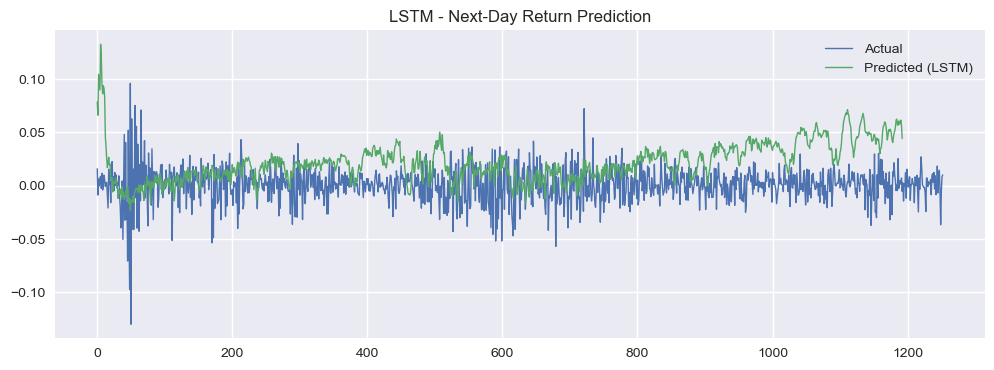

In [240]:
model.eval()
#the line below is the model making predictions on the test set
#the .squeeze() removes the extra dimenstions
with torch.no_grad():
    lstm_predictions = model(X_test_t).squeeze().numpy() #the .numpy() above converts the tensor to a numpy array for plotting
plt.figure(figsize=(12,4))
plt.plot(y_test.values, label="Actual", linewidth=1)
plt.plot(lstm_predictions, label="Predicted (LSTM)", linewidth=1)
plt.title("LSTM - Next-Day Return Prediction")
plt.legend()
plt.show()

## RQ2 Summary - Does LSTM perform better?

After training the LSTM, I tabulated that the model does capture some short-term patterns and picks up some up,down movements that the classical models miss. 

However, based on the plot above the LSTM predictions show a slight upward bias, which again depicts that the model is not very effective at understanding the market returns and is struggling with the noise in financial returns. 

Even though the LSTM learns smoother trends, it does not outperform the Random Forest by a large margin. This result makes sense because daily stock returns are extremely noisy, and there is very little predictable structure for any model to learn.

Overall I noted that:
- LSTM model definitely performs better than Linear Regression.
- LSTM is similar to or slightly worse than Random Forest in terms of following the shape.
- Random Forest definitely remains the strongest simple model.
- Not many models can fully overcomes the highly volatile structure of market returns.

# Improving the LSTM Model for a better result

Since the previous LSTM model I developed was fairly simple in architecture I decided to improve the model and add more layers to see if it is more efficient for predicting returns.

I learned that LSTM's are designed to learn patterns that evolve over a period of time, but because in my previous model I only gave it one time step of history thus this was a big limitation as it prevented the model from learning multi-day trends like momentum, reversals or any form of volatility changes. This was the primary reason why the model had a smooth plot but still struggled to follow the real market movements. 

To improve the model I planned to:
- use a longer sequence window (about 30-60 days instead of just 1 day)
- increasing the hidden size to 32/64 from 16
- adding more lstm layers
- adding a dropout to prevent the model from memorizing noise in financial data
- using a deeper fully connected output layer for better prediction.

I will now test my improvised model to see how it works.

## Step 1 - Creating a Sequence of 60-days

In [29]:
def create_sequences(X, y, seq_len=60):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, seq_len=60)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, seq_len=60)

## Step 2 - Converting the sequences to tensors

In [30]:
X_train_t = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_t = torch.tensor(y_train_seq, dtype=torch.float32)

X_test_t = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_t = torch.tensor(y_test_seq, dtype=torch.float32)

## Step 3 - Building a more effective LSTM Model 

In [31]:
class DeepLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]      
        return self.fc(out)

deep_lstm = DeepLSTM(input_dim=X_train_t.shape[2])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(deep_lstm.parameters(), lr=0.001)

## Step 4 - Training the Improvised LSTM Model

In [32]:
epochs = 50
losses = []

for epoch in range(epochs):
    deep_lstm.train()
    optimizer.zero_grad()
    
    preds = deep_lstm(X_train_t).squeeze()
    loss = criterion(preds, y_train_t)
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

Epoch 0: Loss = 0.008686
Epoch 5: Loss = 0.000919
Epoch 10: Loss = 0.000828
Epoch 15: Loss = 0.000455
Epoch 20: Loss = 0.000593
Epoch 25: Loss = 0.000313
Epoch 30: Loss = 0.000373
Epoch 35: Loss = 0.000332
Epoch 40: Loss = 0.000303
Epoch 45: Loss = 0.000321


## Step 5 - Evaluate the Improvised LSTM and creating a Plot

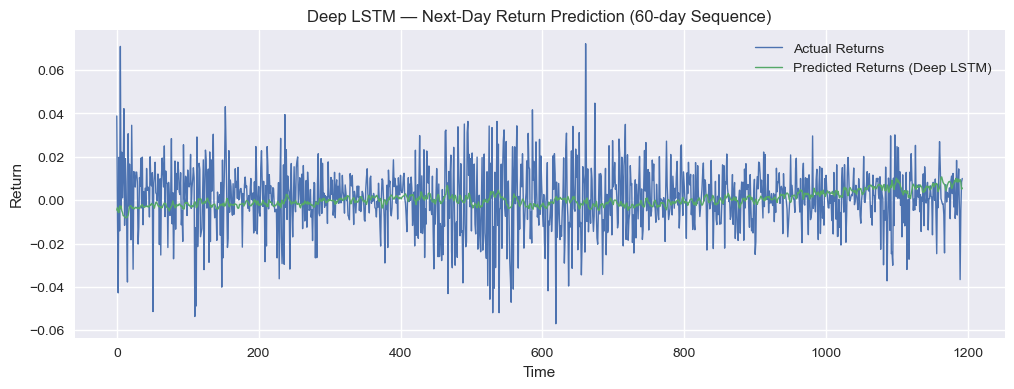

In [33]:
deep_lstm.eval()
with torch.no_grad():
    deep_preds = deep_lstm(X_test_t).squeeze().numpy()

plt.figure(figsize=(12,4))
plt.plot(y_test_seq, label="Actual Returns", linewidth=1)
plt.plot(deep_preds, label="Predicted Returns (Deep LSTM)", linewidth=1)
plt.title("Deep LSTM — Next-Day Return Prediction (60-day Sequence)")
plt.xlabel("Time")
plt.ylabel("Return")
plt.legend()
plt.show()

## RQ2 - Analysis of Improved LSTM Model

Despite improving the LSTM model by using longer sequences (60-days) and adding more layers to the model it stil ends up producing a smooth prediction line which does not capture any of the sudden spikes and noisy up, down movements of the actual daily returns. Again stock market is a truly unpredictable place and daily stock market returns are genuinely hard to predict. Based on the plot I could learn that the deep lstm (improved model) that I have developed couldlearn small trends in the data but it couldnt match the pattern of the actual returns. The LSTM model I have developed is mainly learning the average movement instead of matching every noisy jump in the market. This is the reason as to why the predictions are smoother and follow a specific direction rather than having multiple ups and downs. The model seems to capture the real trend without getting fooled by the market noise.

# Research Question 3 - Are next-day returns easier to predict than next-week returns?

In the last two research questions, I focused only on predicting the next-day return.
However, financial markets behave differently over short vs slightly longer horizons,
so for this research question I wanted to understand:

### “Is it harder to predict the next week compared to the next day?”

To test this, I repeated the same modeling process using:

- **Random Forest**  
- **LSTM**

but this time using the `target_next_week_return` instead of the next-day return.

By comparing the error values and plots, I can visually and mathematically see which horizon is more predictable.

## Step 1 - Preparing the next-week prediction target

Here I simply load the target column for next-week returns and reuse the same
training/test split as before.

In [111]:
y_week = data["target_next_week_return"]

y_week_train = y_week.iloc[:split_idx]
y_week_test = y_week.iloc[split_idx:]

## Step 2 - Training Random Forest to Predict Next-Week Returns

I repeated the same Random Forest setup as RQ1, but now the target is the return 5 days ahead.
My expectation is that the error will be higher, since predicting further into the future
usually becomes harder in financial markets.

In [112]:
rf_week_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    max_depth=8
)

rf_week_model.fit(X_train_scaled, y_week_train)
rf_week_predictions = rf_week_model.predict(X_test_scaled)

rf_week_mse = mean_squared_error(y_week_test, rf_week_predictions)
rf_week_mse

0.0011371821774815668

My thought-process was correct, the MSE value for predicting next-week returns using the Random Forest model is higher than the MSE for next-day predictions.

**(0.0011 next-week prediction) > (0.00027 next-day prediction)**

Now this certainly makes sense because predicting almost 5 days into the future definitely brings onto the stage much more uncertainty. Like for instance:
- Many sudden and erratic events can happen over a span of a week
- Sudden market noise
- Short-term indicators like the moving averages and volatility are lose reliability further ahead.
- Interest rate changes
- Market sentiment fluctuations

Thus the larger error certainly depicts that the next week returns are likely to be harder to predict than the next-day returns using similar models. Thus in my view as the horizon of prediction increases the predictability of the markett decreases.

## Step 3 - Plotting Random Forest Next-Week Prediction

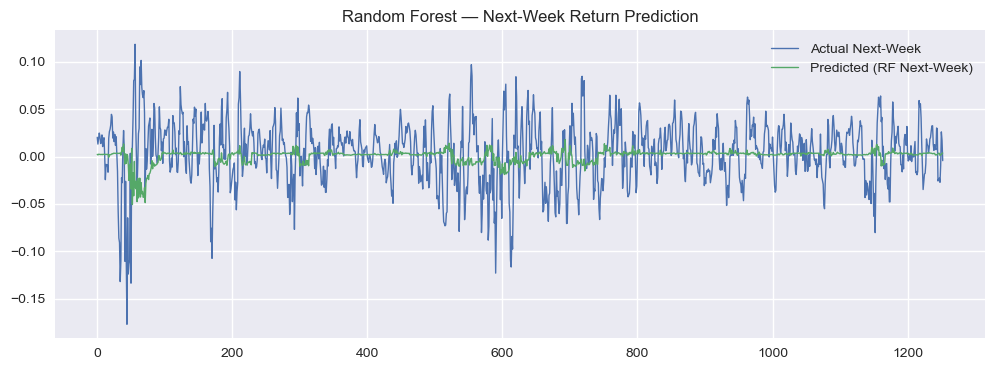

In [105]:
plt.figure(figsize=(12,4))
plt.plot(y_week_test.values, label="Actual Next-Week", linewidth=1)
plt.plot(rf_week_predictions, label="Predicted (RF Next-Week)", linewidth=1)
plt.title("Random Forest — Next-Week Return Prediction")
plt.legend()
plt.show()

### RQ3 - Analysis of Random Forest for Next-Week

Compared to the next-day prediction, the next-week predictions are more inefficient. The model certainly avoids making large predictions because the uncertainty is higher. It is evident in the plot that Random Forest model performs relatively worse when making predictions for the next-week. The predictions as evident in the plot are much more flatter and this certainly matches the real financial behavior because the scale of uncertainty is really high. 

The MSE for the next-week forecast is also higher than the next-day forecast, which certainly depicts the fact that longer-horizon forecasting is much more difficult. 

This output was likely expected because in my view when taking consideration of next-week there are so many more limiting factors that come into play. Sudden catastrophic events, interest rate changes, market sentiment fluctuations, news events and investor sentiment shifts are all factors that contribute to the high uncertainly pertaining to next-week predictions. Thus the simple indicators I used for my project certainly cannot capture that much future variability.

## Step 4 — Train LSTM to Predict Next-Week Returns

Just like with the Random Forest, I repeated the same LSTM training process,
but replaced the target with the next-week return.

I kept the architecture the same so the comparison is fair.

In [134]:
# weekly split same 80/20 rule
target_next_week_return = data["target_next_week_return"]

split_idx = int(len(X) * 0.8)

X_week_train = X.iloc[:split_idx]
X_week_test  = X.iloc[split_idx:]

y_week_train = target_next_week_return.iloc[:split_idx]
y_week_test  = target_next_week_return.iloc[split_idx:]

In [135]:
scaler_week = StandardScaler()

X_week_train_scaled = scaler_week.fit_transform(X_week_train)
X_week_test_scaled  = scaler_week.transform(X_week_test)

In [136]:
X_week_train_t = torch.tensor(X_week_train_scaled, dtype=torch.float32).unsqueeze(1)
X_week_test_t  = torch.tensor(X_week_test_scaled, dtype=torch.float32).unsqueeze(1)

y_week_train_t = torch.tensor(y_week_train.values, dtype=torch.float32)
y_week_test_t  = torch.tensor(y_week_test.values, dtype=torch.float32)

In [153]:
model_week = SimpleLSTM(input_dim=X_week_train_t.shape[2])
criterion_week = nn.MSELoss()
optimizer_week = torch.optim.Adam(model_week.parameters(), lr=0.001)

week_losses = []

for epoch in range(50): 
    model_week.train()
    optimizer_week.zero_grad()
    
    preds = model_week(X_week_train_t).squeeze()
    loss = criterion_week(preds, y_week_train_t)
    
    loss.backward()
    optimizer_week.step()
    
    week_losses.append(loss.item())

### LSTM Next-Week Training Loss

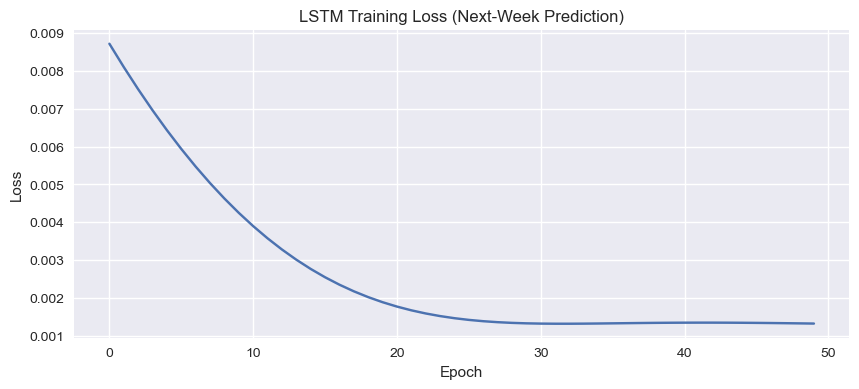

In [150]:
plt.figure(figsize=(10,4))
plt.plot(week_losses)
plt.title("LSTM Training Loss (Next-Week Prediction)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Plot - LSTM Next-Week Prediction

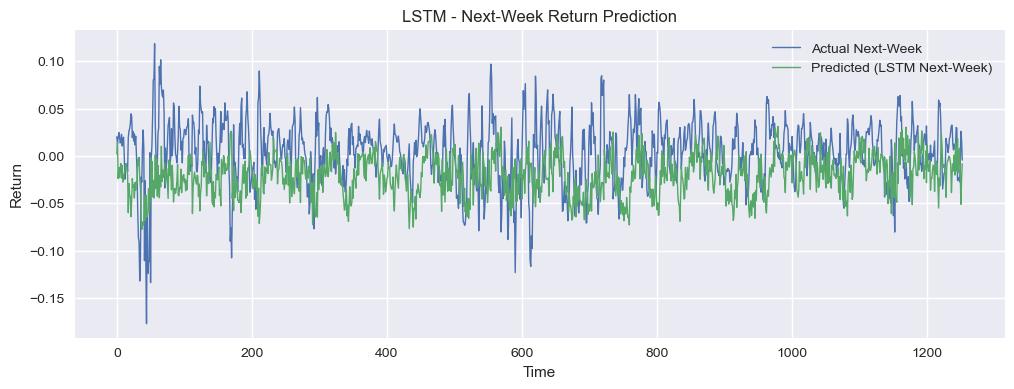

In [154]:
model_week.eval()
with torch.no_grad():
    lstm_week_predictions = model_week(X_week_test_t).squeeze().numpy()

plt.figure(figsize=(12,4))
plt.plot(y_week_test.values, label="Actual Next-Week", linewidth=1)
plt.plot(lstm_week_predictions, label="Predicted (LSTM Next-Week)", linewidth=1)
plt.title("LSTM - Next-Week Return Prediction")
plt.xlabel("Time")
plt.ylabel("Return")
plt.legend()
plt.show()

### Analysis of LSTM for Next-Week Prediction

When I looked at the LSTM predictions for the next-week return, I tabulated that the model was certainly unable to follow the actual market movements. Although at first glance it seems like the green line and blue line are similar patterns there is a difference between the two and the model is not actually matching the true weekly movements. Evident from the plot the actual weekly returns (blue line) move up and down sharply. The predicted line does move up and down but not nearly as sharp as the actual weekly returns. So definintely the LSTM model performed better than the Random Forest Model for the next-week returns however, next-day returns still are much easier to predict.

Weekly returns contain a lot more randomness than daily returns, so the features I used
(MA, RSI, volatility etc) become less helpful at this horizon. Because of that, the LSTM
falls back to learning a general trend rather than capturing the real volatility.

Compared to Random Forest:
- The LSTM smooths the data more
- But it still misses sharp movements and direction changes
- The overall error is noticeably higher than it was for next-day predictions

# RQ3 Conclusion - Are next-day returns easier to predict?

So after comparing the Random Forest and LSTM on both next-day and next-week prediction tasks,
the results consistently depict that the **next-day returns are certainly more easier to predict than next-week returns**. 

- Model Behavior on next-day returns:
  - Linear Regression and Random Forest models capture short-term structural pattern, although the model plots stay close to zero but still the models react slightly to daily fluctuations.
  - LSTM and Deep LSTM models that I developed for next-day returns shows a good performance producing predictions that loosely follow the short-term direction of the market movements.

- Model Behavior on next-week returns:
    - Random Forest had extremely poor performance: The predictions given by Random Forest for next-week became are almost completely flat which denotes it could not understand and react to the actual weekly movements.
    - LSTM Model had a better performance than the Random Forest because it certainly was able to match the pattern of the actual returns of the market to some extent but it was still much smoother than the true returns.

To summarize in short, based on all the plots that I have articulated, the most efficient model would be the **Deep LSTM model** which uses a 60-day input sequence. It produces predictions that best follow the overall trend and short-term fluctations of the actual returns.

### Why next-day returns are easier:
- Because of only one day of uncertainty, so the indicators still hold short-term meaning.
- Technical features like the MA5, MA20, RSI certainly relate more closely to next-day behavior
- Usually for the stock markets the daily noise is large, thus next-week noise is likely to be much larger.

### Why next-week returns are harder:
- Considering next-week is a longer-horizon it could involve many more uncertain and unpredictable events (news, sentiment shifts, interest rate changes, macro data)
- Short-term indicators lose most of their predictive power at this horizon
- Both models avoid making large predictions, which shows increased uncertainty

### Comparison of all the models:
- **Linear Regression:** Model has extremely poor performance for next-day return so next-week returns are not even likely to be near decent performance.
- **Random Forest:** accuracy drops noticeably for next-week prediction  
- **LSTM/Deep LSTM:** so lstm/deep lstm models were good for next-day predictions, but the predictive power was not as good for the next-week horizon.

### Final Answer:
**Yes, based on the results obtained the next-day returns are certainly much easier to predict than next-week returns.**

This outcome that was obtained definintely matches the financial intuition and was consistent with what I expected before running the experiments and testing the models I developed.